In [86]:
from imm import imm
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[[ -7.81038741  -2.68580831]
 [ -5.55813374 -19.38698589]
 [  0.80666128  -1.6256129 ]
 [ 16.60072664   3.26839319]
 [  3.53086577  21.38301642]
 [  1.12995265  10.17494173]
 [  8.68208866   2.51148503]
 [  8.00966402  -2.4062125 ]
 [  4.06505244  -7.6485036 ]
 [  3.4965967   14.50151952]]


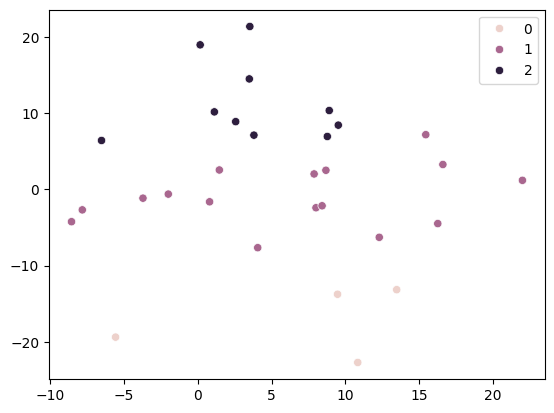

In [87]:
dims = 2
n = 30
k = 3

X, y_ = make_blobs(centers=k, cluster_std=8, n_features=dims, n_samples=n)
model = KMeans(n_clusters=k)
model.fit(X)
centers = model.cluster_centers_
y = model.predict(X)
# pca = PCA(n_components=2)
# embed_X = pca.fit_transform(X)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, legend='full')

#initialize with 2 clusters
# X = np.array([[1, 2], [1, 4], [1, 0],
#               [10, 2], [10, 4], [10, 0]])

print(X[:10])

In [88]:
instance_index = y.argmin()
instance = X[instance_index]
target_class = 2
target_point = centers[target_class, :]

print("")
print(f"Instance class: {y[instance_index]}, point: {instance}")
print(f"Target center class: {target_class}, point: {target_point}\n")


Instance class: 0, point: [ -5.55813374 -19.38698589]
Target center class: 2, point: [ 3.54045783 11.32027259]



# SKLearn Decision Tree Classifier

In [96]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X, y)
print(f"Accuracy: {clf.score(X, y)}")

n_leaves = clf.get_n_leaves()
n_total_nodes = clf.tree_.node_count
n_internal_nodes = n_total_nodes - n_leaves

tree_model = clf.tree_
feature = tree_model.feature
threshold = tree_model.threshold
parent = np.full(n_total_nodes, -1, dtype=int)
for i in range(n_total_nodes):
    if tree_model.children_left[i] != -1:
        parent[tree_model.children_left[i]] = i
    if tree_model.children_right[i] != -1:
        parent[tree_model.children_right[i]] = i

print("Parent list: ", parent)


print(f"Number of leaves: {n_leaves}")
print(f"Number of nodes: {n_total_nodes}")
print(f"Number of internal nodes: {n_internal_nodes}")

target_leafs = np.array([x for x in range(n_total_nodes) if tree_model.children_left[x] == -1 and np.argmax(tree_model.value[x]) == target_class])
print("Leaf Ids for target class: ", target_leafs)

print(f"Instance class: {y[instance_index]}, point: {instance}")
print(f"Target center class: {target_class}, point: {target_point}")

inst = np.array([instance])
targ = np.array([target_point])
inst = inst.astype(np.float32)
targ = targ.astype(np.float32)


inst_node_indicator = np.array(tree_model.decision_path(inst).todense())[0]
inst_leaf_id = tree_model.apply(inst)

target_node_indicator = np.array(tree_model.decision_path(targ).todense())[0]
target_leaf_id = tree_model.apply(targ)

# path_len = min(inst_node_indicator.shape[0], target_node_indicator.shape[0])
# path_equality = inst_node_indicator[:path_len] & target_node_indicator[:path_len]
# last_equal_parent = np.nonzero(path_equality)[0].max()
# print("Index in tree of parent equality: ", last_equal_parent)

# temp = np.nonzero(target_node_indicator)[0]
# temp = temp[temp >= last_equal_parent]

# path_of_changes = set(temp)

# print("-----------------------------------------------------------------------------------------")
# print("Path of changes: ", path_of_changes)

# cf = instance.copy() # counterfactual

# curr_node = last_equal_parent
# i = 0
# print("  ", cf)
# while len(path_of_changes) > 1:
#     path_of_changes.remove(curr_node)
#     if tree_model.children_left[curr_node] in path_of_changes:
#         print(f"Change {i}: Left child")
#         if cf[feature[curr_node]] >= threshold[curr_node]:
#             cf[feature[curr_node]] = threshold[curr_node] - 0.0001
#         curr_node = tree_model.children_left[curr_node]
#     elif tree_model.children_right[curr_node] in path_of_changes:
#         print(f"Change {i}: Right child")
#         if cf[feature[curr_node]] < threshold[curr_node]:
#             cf[feature[curr_node]] = threshold[curr_node]
#         curr_node = tree_model.children_right[curr_node]
#     else:
#         print("CHILD COULD NOT BE LOCATED!!!!!")
#         break
#     i += 1
#     print("  ", cf)

# print(f"Counterfactual prediction: {clf.predict([cf])}")

Accuracy: 1.0
Parent list:  [-1  0  1  1  0  4  4]
Number of leaves: 4
Number of nodes: 7
Number of internal nodes: 3
Leaf Ids for target class:  [5]
Instance class: 0, point: [ -5.55813374 -19.38698589]
Target center class: 2, point: [ 3.54045783 11.32027259]


In [100]:
cfs = np.zeros(shape=(target_leafs.shape[0], dims))

for j,l in enumerate(target_leafs):
    print("Instance ID: ", inst_leaf_id)
    print("Target node ID: ", l)
    print("parent list: ", parent)

    target_node_indicator = np.zeros(shape=(n_total_nodes), dtype=int)
    curr_node = l
    print("Leaf node: ", curr_node)
    while parent[curr_node] != -1:
        target_node_indicator[curr_node] = 1
        curr_node = parent[curr_node]
        print("Parent node: ", curr_node)

    target_node_indicator[curr_node] = 1


    inst = np.array([instance])
    inst = inst.astype(np.float32)


    inst_node_indicator = np.array(tree_model.decision_path(inst).todense())[0]

    print("Instance path: ", inst_node_indicator)
    print("Target path: ", target_node_indicator)

    path_len = min(inst_node_indicator.shape[0], target_node_indicator.shape[0])
    path_equality = inst_node_indicator[:path_len] & target_node_indicator[:path_len]
    last_equal_parent = np.nonzero(path_equality)[0].max()
    print("Index in tree of parent equality: ", last_equal_parent)

    temp = np.nonzero(target_node_indicator)[0]
    temp = temp[temp >= last_equal_parent]

    path_of_changes = set(temp)

    # print("-----------------------------------------------------------------------------------------")
    # print("Path of changes: ", path_of_changes)

    cf = instance.copy() # counterfactual

    curr_node = last_equal_parent
    i = 0
    # print("  ", cf)
    while len(path_of_changes) > 1:
        path_of_changes.remove(curr_node)
        if tree_model.children_left[curr_node] in path_of_changes:
            # print(f"Change {i}: Left child")
            if cf[feature[curr_node]] >= threshold[curr_node]:
                cf[feature[curr_node]] = threshold[curr_node] - 0.0001
            curr_node = tree_model.children_left[curr_node]
        elif tree_model.children_right[curr_node] in path_of_changes:
            # print(f"Change {i}: Right child")
            if cf[feature[curr_node]] < threshold[curr_node]:
                cf[feature[curr_node]] = threshold[curr_node]
            curr_node = tree_model.children_right[curr_node]
        else:
            print("CHILD COULD NOT BE LOCATED!!!!!")
            break
        i += 1
        # print("  ", cf)

    print(f"Counterfactual prediction: {clf.predict([cf])}")
    print("-----------------------------------------------------------------------------------------")
    cfs[j] = cf
print("Counterfactuals: ")
print(cfs)

Instance ID:  [2]
Target node ID:  5
parent list:  [-1  0  1  1  0  4  4]
Leaf node:  5
Parent node:  4
Parent node:  0
Instance path:  [1 1 1 0 0 0 0]
Target path:  [1 0 0 0 1 1 0]
Index in tree of parent equality:  0
Counterfactual prediction: [1]
-----------------------------------------------------------------------------------------
Counterfactuals: 
[[-5.55813374  4.84473813]]


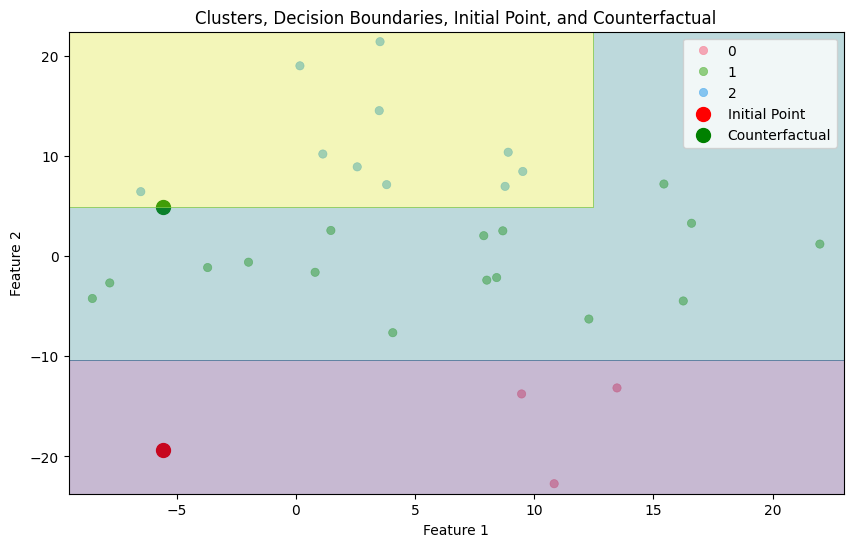

In [91]:
# Assuming X, y, instance, target_point, cf, and tree_model are already defined

# Plot the data points and clusters
plt.figure(figsize=(10, 6))
unique_labels = np.unique(y)
palette = sns.color_palette("husl", len(unique_labels))  # Use a distinct color palette
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=palette, alpha=0.6, edgecolor=None, legend='full')

# Plot the initial point
plt.scatter(instance[0], instance[1], color='red', s=100, label='Initial Point')

# Plot the counterfactual
plt.scatter(cf[0], cf[1], color='green', s=100, label='Counterfactual')

# Plot the decision boundaries
plot_step = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Clusters, Decision Boundaries, Initial Point, and Counterfactual')
plt.show()

## Visualize tree and path example

Instance leaf id: [2]
Rules used to predict sample 0:

decision node 0 : (X_test[0, 1] = -19.386985778808594) <= 4.844738125801086)
decision node 1 : (X_test[0, 1] = -19.386985778808594) <= -10.404365301132202)


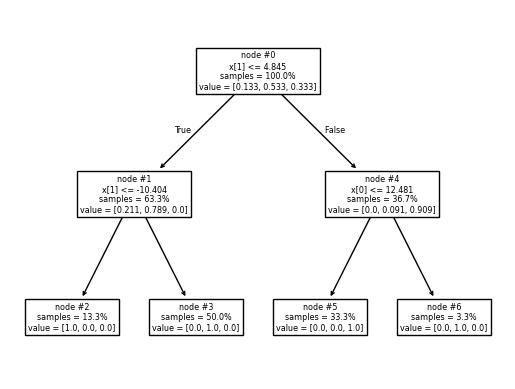

In [92]:
# Following code is from: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

inst_node_indicator = tree_model.decision_path(inst)
inst_leaf_id = tree_model.apply(inst)
print(f"Instance leaf id: {inst_leaf_id}")
# print(f"Target leaf id: {target_leaf_id}")


# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
sample_id = 0
node_index = inst_node_indicator.indices[
    inst_node_indicator.indptr[sample_id] : inst_node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if inst_leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if inst[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=inst[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

tree.plot_tree(clf, proportion=True, node_ids=True, impurity=False)
plt.show()

# IMM

In [93]:
imm_model = imm()
imm_model.fit(X, y, centers)

print(imm_model.write_tree())

instance_path = imm_model.get_path(instance)
target_path = imm_model.get_path(target_point)
print(f"Instance path: {instance_path}")
print(f"Target path: {target_path}\n")

path_len = min(len(instance_path), len(target_path))
path_equality = instance_path[:path_len] == target_path[:path_len]
last_equal_parent = np.nonzero(path_equality)[0].max()
print("Index in tree of parent equality: ", last_equal_parent)
path_of_changes = target_path[last_equal_parent:]
print("Path of changes: ", path_of_changes)

cf = instance.copy()

for i in range(len(path_of_changes) - 1):
    print(f"Change {i}:")
    curr_node = path_of_changes[i]
    if curr_node.left == path_of_changes[i+1]:
        if cf[curr_node.feature] >= curr_node.threshold:
            cf[curr_node.feature] = curr_node.threshold - 0.0001
    else:
        if cf[curr_node.feature] < curr_node.threshold:
            cf[curr_node.feature] = curr_node.threshold

print("Counterfactual: ", cf)

├── L0: 1 < -2.9675263656307935
│   ├── L1, C: 0
│   └── L1: 1 < 5.205146797379841
│       ├── L2, C: 1
│       └── L2, C: 2

Instance path: [<imm.Node object at 0x747df377a140> <imm.Node object at 0x747df377b460>]
Target path: [<imm.Node object at 0x747df377a140> <imm.Node object at 0x747df96ed2d0>

Index in tree of parent equality:  0
Path of changes:  [<imm.Node object at 0x747df377a140> <imm.Node object at 0x747df96ed2d0>
Change 0:
Change 1:
Counterfactual:  [-5.55813374  5.2051468 ]


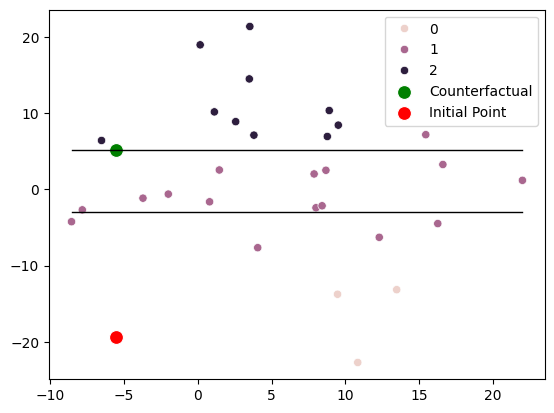

In [94]:
def plot_decision_boundaries(node, x_min, x_max, y_min, y_max, depth=0):
    if node is None or node.cluster is not None:
        return
    
    if node.feature == 0:
        plt.plot([node.threshold, node.threshold], [y_min, y_max], 'k-', lw=1)
        plot_decision_boundaries(node.left, x_min, node.threshold, y_min, y_max, depth + 1)
        plot_decision_boundaries(node.right, node.threshold, x_max, y_min, y_max, depth + 1)
    elif node.feature == 1:
        plt.plot([x_min, x_max], [node.threshold, node.threshold], 'k-', lw=1)
        plot_decision_boundaries(node.left, x_min, x_max, y_min, node.threshold, depth + 1)
        plot_decision_boundaries(node.right, x_min, x_max, node.threshold, y_max, depth + 1)

# Assuming imm_model is an instance of the imm class and has been fitted
tree = imm_model.tree

# Plot the data points
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, legend='full')
sns.scatterplot(x=[cf[0]], y=[cf[1]], color='green', s=100, label='Counterfactual')
sns.scatterplot(x=[instance[0]], y=[instance[1]], color='red', s=100, label='Initial Point')

# Plot the decision boundaries
plot_decision_boundaries(tree, X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max())

plt.show()